In [378]:
# Filter trajectories to maximum length to not overrepresent long trajectories that are often artifactual
# Very low fraction of trajectories are longer than 10 frames

import pandas as pd
import numpy as np

max_length = np.inf
min_length = 3

paths = pd.read_csv('../data/single-molecule-tracking/experiment_conditions.csv')

for i in range(len(paths)):
    print(i+1,'of',len(paths))
    df = pd.read_csv(paths.iloc[i].filepath)
    
    n_frames = np.zeros(int(df.trajectory.max()))
    for t in df.trajectory.to_numpy(dtype=np.integer):
        n_frames[t-1] += 1

    # filtered_trajectories = list(np.nonzero(n_frames<=max_length)[0])
    filtered_trajectories = list(np.nonzero(n_frames>=min_length)[0])

    df.query('trajectory==@filtered_trajectories').to_csv(paths.iloc[i].filepath[:-4] + '.filtered' + '.csv')

1 of 19
2 of 19
3 of 19
4 of 19
5 of 19
6 of 19
7 of 19
8 of 19
9 of 19
10 of 19
11 of 19
12 of 19
13 of 19
14 of 19
15 of 19
16 of 19
17 of 19
18 of 19
19 of 19


In [386]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pickle
from saspt import RBME, GAMMA, StateArrayDataset

# parameters
paths = pd.read_csv('../data/single-molecule-tracking/experiment_conditions.csv')

file_name = "../data/single-molecule-tracking/2024_03_06_200_unfiltered_all_occupancy.pkl" # primary analysis with params above

# Secondary analyses to see if increased iterations reveals anything significant; narrowed distributions but nothing novel emerging
# file_name = "../data/single-molecule-tracking/2024_03_06_1000_unfiltered_all_occupancy.pkl" # secondary analysis with 1000 iterations

# Secondary analyses filtering out rare, long trajectories that can be immobile spots (limit to <=10 frames total length)
# file_name = "../data/single-molecule-tracking/2024_03_05_1000_filtered_long_all_occupancy.pkl" # 1000 iterations
# file_name = "../data/single-molecule-tracking/2024_03_05_200_filtered_long_all_occupancy.pkl" # 200 iterations

# Secondary analyses filtering out short trajectories that can be mistaken assignment (limit to >=3 frames total length)
# file_name = "../data/single-molecule-tracking/2024_03_06_200_filtered_short_all_occupancy.pkl" # 200 iterations

figure_prefix = '../figures/figure-4/smt-outputs/'
load_file = True
use_filtered_trajectories = False

settings = dict(
    likelihood_type = RBME, # primary analysis
    # likelihood_type = GAMMA, # test robustness w/ gamma
    # loc_error = 0.025, # fix localization error with gamma
    pixel_size_um = 0.1,
    frame_interval = 0.033,
    focal_depth = 0.5, # based on empirical observation of track localizations relative to cell width
    path_col = 'filepath',
    condition_col = 'condition',
    progress_bar = True,
    max_iter = 200, # default 200
    sample_size = 1e9, # no max
    splitsize = 10, # default 10
    diff_coefs=np.logspace(-2.0, 1.0, 100)  # 100 diff coefs from 0.01 to 10.0; this should work to change range
)

if use_filtered_trajectories:
    for i in range(len(paths)):
        paths.loc[i,'filepath'] = paths.iloc[i].filepath[:-4] + '.filtered' + '.csv'

# # single file
# paths = paths.iloc[[0]]

# single condition
# paths = paths.query('condition=="PerMn1 FtsBΔLQ mEos3.2"')

# load or calculate SAD
if load_file:
    with open(file_name, "rb") as file:
        SAD,marginal_naive_occs,marginal_posterior_occs,posterior_occs,posterior_names = pickle.load(file)
else:
    SAD = StateArrayDataset.from_kwargs(paths, **settings)

# print(SAD.raw_track_statistics)
print(SAD.params)
# print(SAD)

StateArrayParameters:
  pixel_size_um:	0.1
  frame_interval:	0.033
  focal_depth:	0.5
  splitsize:	10
  sample_size:	1000000000.0
  start_frame:	0
  max_iter:	200
  conc_param:	1.0


In [381]:
marginal_naive_occs = SAD.marginal_naive_occs
marginal_posterior_occs = SAD.marginal_posterior_occs
SAD.posterior_heat_map(figure_prefix + 'posterior_heat_map.png')
SAD.posterior_line_plot(figure_prefix + 'posterior_line_plot.png')
SAD.naive_heat_map(figure_prefix + 'naive_heat_map.png')
SAD.naive_line_plot(figure_prefix + 'naive_line_plot.png')

[########################################] | 100% Completed | 28.55 s
[########################################] | 100% Completed | 303.55 s


In [382]:
# Infer posterior occupancies aggregating conditions
posterior_occs, posterior_names = SAD.infer_posterior_by_condition('condition')

In [383]:
# Save all occupancy estimates
import pickle
file_name = "../data/single-molecule-tracking/2024_03_06_200_filtered_short_all_occupancy.pkl"
    
with open(file_name, "wb") as file:
    pickle.dump([SAD,
                 marginal_naive_occs,
                 marginal_posterior_occs,
                 posterior_occs,
                 posterior_names], file)

PerMn1 FtsBΔLQ mEos3.2	0.23101297000831603	0.16639276359310753
PerMn1 FtsBΔLQ mEos3.2	0.1873817422860384	0.15596000865042217
PerMn1 FtsBΔLQ mEos3.2	0.14174741629268056	0.16093010676532174
PerMn1 FtsBΔLQΔH mEos3.2	0.26560877829466867	0.21091482574482387
PerMn1 FtsBΔLQΔH mEos3.2	0.24770763559917114	0.20289499296541408
PerMn1 FtsBΔLQΔH mEos3.2	0.24770763559917114	0.19620173029791896


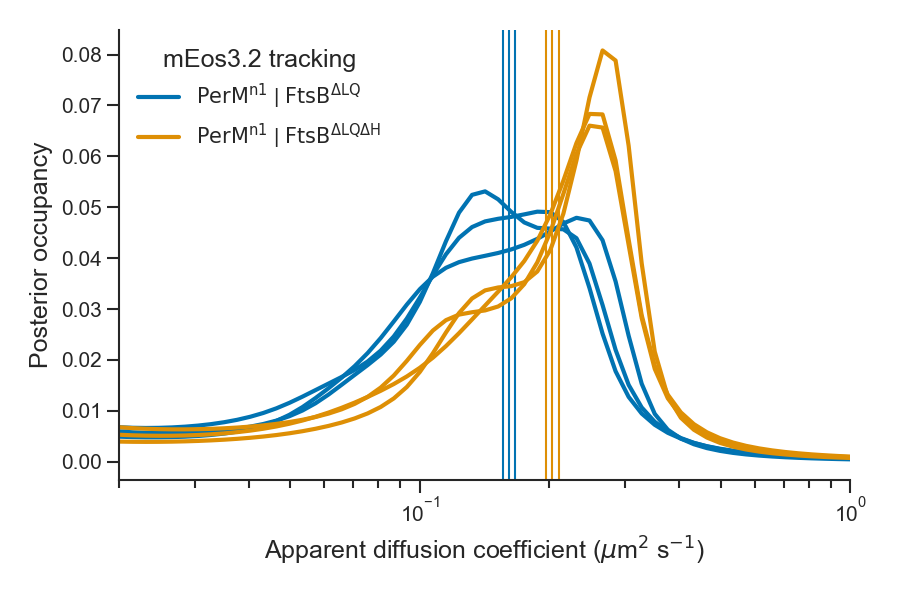

In [387]:
# Figure 4b

import seaborn as sns

sns.set_theme(style='ticks',
              palette=sns.color_palette('colorblind'),
              font='Arial',
              rc={'figure.dpi': 300,
                  'figure.figsize':(7.2,4), # 7.2 inch is full page width
                  'axes.spines.right':False,
                  'axes.spines.top':False,
                  'axes.linewidth':0.5,
                  'font.size':7,
                  'xtick.labelsize':5,
                  'ytick.labelsize':5,
                  'xtick.major.pad':1,
                  'ytick.major.pad':1,
                  'xtick.major.size':3,
                  'ytick.major.size':3,
                  'xtick.minor.size':2,
                  'ytick.minor.size':2,
                  'xtick.major.width':0.5,
                  'ytick.major.width':0.5,
                  'xtick.minor.width':0.5,
                  'ytick.minor.width':0.5,
                  'axes.titlesize':6,
                  'axes.labelsize':6,
                  'legend.fontsize':5,
                  'legend.title_fontsize':6,
                  'axes.labelpad':2})

xlim = [0.02, 1.0]
ylim = [0,0.11]
plot_cumsum = False
use_n = [0,1]

sep = ' | '
pretty_labels = {'PerMn1 FtsBΔLQ':r'$\text{PerM}^\text{n1}$' + sep + r'$\text{FtsB}^\text{ΔLQ}$',
                'PerMn1 FtsBΔLQΔH':r'$\text{PerM}^\text{n1}$' + sep + r'$\text{FtsB}^\text{ΔLQΔH}$',
                'PerMn1 uninduced FtsBΔLQ':r'$\mathbf{↓}\text{PerM}^\text{n1}$' + sep +  r'$\text{FtsB}^\text{ΔLQ}$',
                'Pf3 FtsBΔLQ':r'$\text{Pf3}$' + sep +  r'$\text{FtsB}^\text{ΔLQ}$',
                'Pf3 FtsBΔLQΔH':r'$\text{Pf3}$' + sep +  r'$\text{FtsB}^\text{ΔLQΔH}$'}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_values = list(pretty_labels.values())
color_dict = {}
for i in range(len(label_values)):
    color_dict[label_values[i]] = colors[i]

dists = {c: SAD.marginal_posterior_occs[df.index,:].copy() \
                for c, df in SAD.paths.groupby(SAD.condition_col)}
diff_coefs=SAD.likelihood.diff_coefs
use_coefs = (xlim[0]<=diff_coefs)&(diff_coefs<=xlim[1])
plt_coefs = diff_coefs[use_coefs]
condition_names = SAD.conditions

fig = plt.figure(figsize=(3,2))

subplt_idx = 0

for n in use_n:

    for i in range(len(dists[condition_names[n]])):
        sample_data = dists[condition_names[n]][i,:]
        sample_data = sample_data[use_coefs]
        normalization = sample_data.sum()
        sample_data = sample_data/normalization
        sample_data = dists[condition_names[n]][i,:]
        sample_data = sample_data[use_coefs]
        normalization = sample_data.sum()
        sample_data = sample_data/normalization
        plot_diff_coefs = diff_coefs[use_coefs]

        label = pretty_labels[' '.join(condition_names[n].split(' ')[:-1])]
        c=color_dict[label]
        if i:
            label = None

        if plot_cumsum:
            plt.plot(plt_coefs,sample_data.cumsum(),c=c,label=label,linewidth=1)
        else:
            plt.plot(plt_coefs,sample_data,c=c,label=label,linewidth=1)

        plt.axvline(np.sum(plt_coefs*sample_data),color=c,linestyle='-',linewidth=0.5)
        plt.legend(frameon=False,title='mEos3.2 tracking')
                
        print(condition_names[n],plot_diff_coefs[sample_data.argmax()], np.sum(plot_diff_coefs*sample_data),sep='\t')
    
plt.xscale('log')   

plt.xlabel(r'Apparent diffusion coefficient ($\mu$m$^{2}$ s$^{-1}$)')
plt.ylabel('Posterior occupancy')
plt.xlim(xlim)
# plt.ylim(ylim)
plt.tight_layout()
plt.savefig(figure_prefix + 'replicates_helix_effect.png',dpi=300)
plt.savefig(figure_prefix + 'replicates_helix_effect.svg',dpi=300)

PerMn1 FtsBΔLQ mEos3.2	0.166
PerMn1 FtsBΔLQ mNeonGreen	0.145
PerMn1 FtsBΔLQΔH mEos3.2	0.210
PerMn1 FtsBΔLQΔH mNeonGreen	0.143
PerMn1 uninduced FtsBΔLQ mEos3.2	0.196
Pf3 FtsBΔLQ mEos3.2	0.199
Pf3 FtsBΔLQ mNeonGreen	0.231
Pf3 FtsBΔLQΔH mEos3.2	0.221
Pf3 FtsBΔLQΔH mNeonGreen	0.222


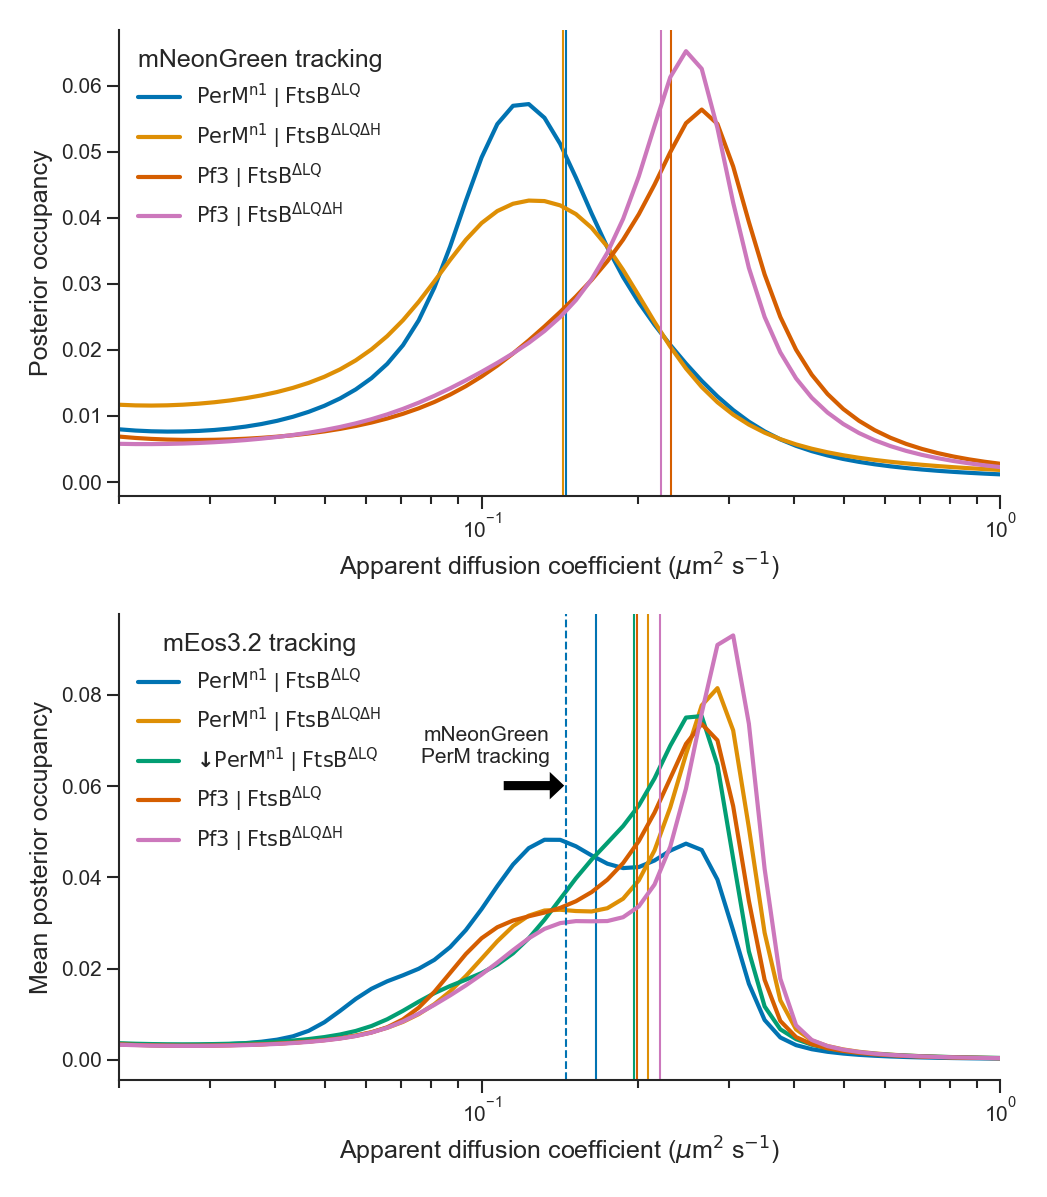

In [388]:
# Normalize and plot together Fig 4c

from saspt import normalize_2d
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pickle, seaborn as sns
from saspt import RBME, StateArrayDataset

# exclude very close to zero to reduce noise and improve normalization
use_occs = posterior_occs[:,use_coefs]
use_occs = normalize_2d(use_occs, axis=1)
mean_PerM_coef = np.sum(plt_coefs * use_occs[1,:])

fig,ax = plt.subplots(2,1,sharex=False,sharey=False,figsize=(3.5,4))

for c in range(use_occs.shape[0]):

    label = pretty_labels[' '.join(posterior_names[c].split(' ')[:-1])]
    mean_coef = np.sum(plt_coefs*use_occs[c,:])

    if 'mNeonGreen' in posterior_names[c]:
        ax[0].plot(plt_coefs, use_occs[c,:], label=label,linewidth=1,c=color_dict[label])
        ax[0].legend(frameon=False,title='mNeonGreen tracking')
        ax[0].axvline(mean_coef,c=color_dict[label],ls='-',linewidth=0.5)
    else:
        ax[1].plot(plt_coefs, use_occs[c,:], label=label,linewidth=1,c=color_dict[label])
        ax[1].legend(frameon=False,title='mEos3.2 tracking')
        ax[1].axvline(mean_coef,c=color_dict[label],ls='-',linewidth=0.5)

    mean_coef = np.sum(plt_coefs*use_occs[c,:])
    print(posterior_names[c],f'%0.3f'%mean_coef,sep='\t')

ax[1].axvline(mean_PerM_coef,c=list(color_dict.values())[0],linestyle='--',linewidth=0.5)

text_height = ax[1].get_ylim()[1] * 2./3
ax[1].text(mean_PerM_coef-0.01,text_height,'mNeonGreen\nPerM tracking',horizontalalignment='right',size=5)
arrow_width = 0.025
ax[1].arrow(mean_PerM_coef-arrow_width-0.01,text_height-0.005,arrow_width,0,color='k', linewidth=0, width=0.002)
ax[0].set_ylabel('Posterior occupancy')
ax[1].set_ylabel('Mean posterior occupancy')

for i in range(2):
    # ax[i].axvline(mean_PerM_coef,c='k',linestyle='--',linewidth=0.5)
    ax[i].set_xscale('log')
    ax[i].set_xlim(xlim)
    ax[i].set_xlabel(r'Apparent diffusion coefficient ($\mu$m$^{2}$ s$^{-1}$)')

plt.xlabel(r'Apparent diffusion coefficient ($\mu$m$^{2}$ s$^{-1}$)')
plt.tight_layout()
plt.savefig(figure_prefix + 'mNeonGreen_mEos32_diffusion.png',dpi=300)
plt.savefig(figure_prefix + 'mNeonGreen_mEos32_diffusion.svg',dpi=300)
plt.show()